# TSFEL and RF Classifier

## Data Loading

In [1]:
import os
import pandas as pd

In [2]:
master_folder = "../EMG_data_for_gestures-master"
cleaned_data_by_subject = {}

In [3]:
# Loop through each subject's folder
for subject_folder in sorted(os.listdir(master_folder)):
    subject_path = os.path.join(master_folder, subject_folder)

    if os.path.isdir(subject_path):  # Check if it's a directory
        subject_number = int(subject_folder)  # Convert subject folder name to an integer
        
        trials = []
        
        for file_name in sorted(os.listdir(subject_path)):
            if file_name.endswith('.txt'):
                file_path = os.path.join(subject_path, file_name)
                
                # Load the .txt file with proper handling for mixed types and whitespace delimiter
                df = pd.read_csv(file_path, delim_whitespace=True, dtype=str)  # Load as strings to avoid dtype issues

                # Drop 'time' column
                df.drop('time', inplace=True, axis=1)
                
                # Drop rows where 'class' column has NaNs or non-numeric values
                df = df[df["class"].notna() & df["class"].str.isnumeric()]
                
                # Convert 'class' column to integer
                df["class"] = df["class"].astype(int)
                
                # Keep only relevant classes (1 to 6) and drop others
                df = df[df["class"].isin([1, 2, 3, 4, 5, 6])]
                
                # Append the cleaned trial data to the list
                trials.append(df)
        
        # Concatenate trials for the current subject
        subject_data = pd.concat(trials, axis=0).reset_index(drop=True)
        
        # Store the cleaned data for the subject
        cleaned_data_by_subject[subject_number] = subject_data

print(f"Loaded and cleaned data for {len(cleaned_data_by_subject)} subjects.")

Loaded and cleaned data for 36 subjects.


In [4]:
segmented_data_by_subject = {}

# Loop through each subject's cleaned data
for subject_number, subject_data in cleaned_data_by_subject.items():
    segmented_trials = []  # Store segmented data for all trials of this subject

    # Sort trials by 'trial' column if applicable
    if 'trial' in subject_data.columns:
        trials = subject_data.groupby('trial')
    else:
        trials = [(None, subject_data)]  # Single trial case

    # Process each trial separately
    for trial_id, trial_data in trials:
        trial_segments = []  # Store all segments for this trial

        # Identify gesture segments by detecting label changes
        current_label = trial_data.iloc[0]['class']  # Start with the first label
        start_index = 0  # Index for the beginning of the segment

        for i in range(1, len(trial_data)):
            if trial_data.iloc[i]['class'] != current_label:
                # Extract the segment for the current label
                segment = trial_data.iloc[start_index:i]
                trial_segments.append(segment)

                # Update the current label and start index
                current_label = trial_data.iloc[i]['class']
                start_index = i

        # Capture the last segment
        segment = trial_data.iloc[start_index:]
        trial_segments.append(segment)

        # Add the segmented data for this trial
        segmented_trials.extend(trial_segments)

    # Store segmented data for the subject
    segmented_data_by_subject[subject_number] = segmented_trials

print(f"Segmented data for {len(segmented_data_by_subject)} subjects.")

Segmented data for 36 subjects.


## Sliding Window

In [5]:
import numpy as np

In [6]:
def extract_sliding_windows(segmented_data, window_size, stride):
    """
    Extracts sliding windows from segmented data.

    Args:
        segmented_data (dict): Segmented data by subject.
        window_size (int): Number of samples in each window.
        stride (int): Step size between consecutive windows.

    Returns:
        list: A list of tuples where each tuple is (window_data, window_label).
    """
    sliding_windows = []

    for subject, trials in segmented_data.items():
        # print(f"Processing Subject {subject}...")
        
        for segment in trials:
            segment_label = segment['class'].iloc[0]  # The class label for the entire segment
            segment_data = segment.drop(columns=['class']).values  # Drop the label column
            
            # Generate windows from this segment
            for start_idx in range(0, len(segment_data) - window_size + 1, stride):
                window = segment_data[start_idx:start_idx + window_size]
                sliding_windows.append((window, segment_label))
    
    print(f"Extracted {len(sliding_windows)} windows.")
    return sliding_windows

In [7]:
###### Parameters for sliding windows
window_size = 200
stride = 40
# 500 ms; 100 ms was 99%
# 400 ms; 80 ms was 98%
# 300 ms; 60 ms was 97%

# Extract sliding windows from segmented data
sliding_windows = extract_sliding_windows(segmented_data_by_subject, window_size, stride)

# Inspect the number of windows
print(f"Total sliding windows: {len(sliding_windows)}")

# Example: Shape of one window and its label
example_window, example_label = sliding_windows[0]
print(f"Window shape: {example_window.shape}, Label: {example_label}")

Extracted 33615 windows.
Total sliding windows: 33615
Window shape: (200, 8), Label: 1


Selected Window Index: 0
Window Shape: (200, 8) (Rows: Timepoints, Columns: Channels)
Class Label: 1


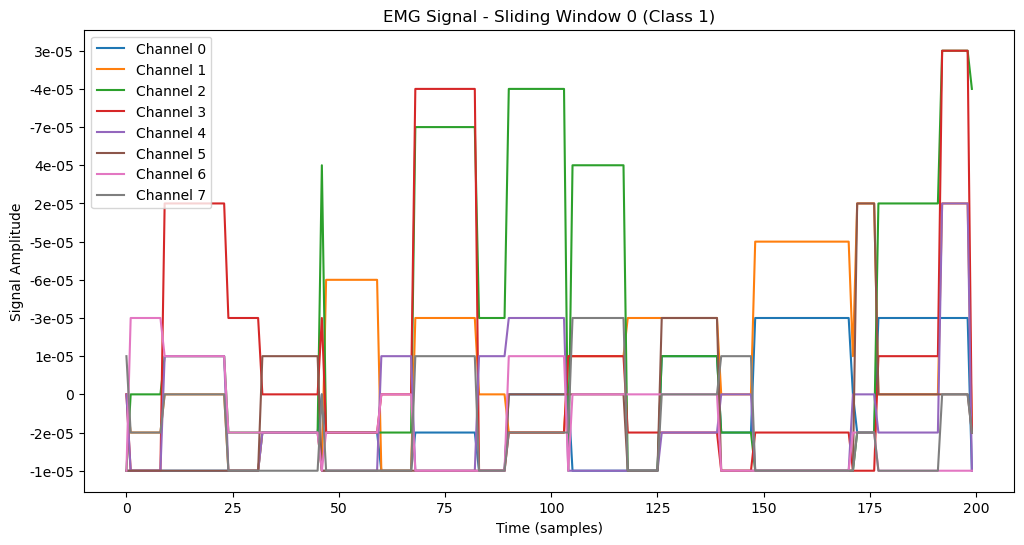

In [8]:
import matplotlib.pyplot as plt

# Select a random window to inspect
window_idx = 0  # Change this to inspect different windows
window_data, window_label = sliding_windows[window_idx]

# Convert to DataFrame for better visualization
window_df = pd.DataFrame(window_data, columns=[f'channel_{i}' for i in range(window_data.shape[1])])

# Print window metadata
print(f"Selected Window Index: {window_idx}")
print(f"Window Shape: {window_df.shape} (Rows: Timepoints, Columns: Channels)")
print(f"Class Label: {window_label}")

# Plot each channel's signal
plt.figure(figsize=(12, 6))
for i in range(window_df.shape[1]):  # Loop through channels
    plt.plot(window_df.index, window_df.iloc[:, i], label=f'Channel {i}')

plt.xlabel("Time (samples)")
plt.ylabel("Signal Amplitude")
plt.title(f"EMG Signal - Sliding Window {window_idx} (Class {window_label})")
plt.legend()
plt.show()

## TSFEL Feature Extraction

In [9]:
import tsfel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [10]:
# Load default TSFEL feature configuration
cfg = tsfel.get_features_by_domain()  # Extracts all features by default

In [11]:
# Initialize feature and label lists
X_features = []
labels = []

# Extract TSFEL features
for window_data, window_label in sliding_windows:
    window_df = pd.DataFrame(window_data, columns=[f'channel_{i}' for i in range(window_data.shape[1])])

    # Extract features
    features_df = tsfel.time_series_features_extractor(cfg, window_df, fs=1000, verbose=0)

    # Store features and labels
    X_features.append(features_df.values.flatten())  # Keep original order
    labels.append(window_label)

# Convert to NumPy arrays
X = np.array(X_features)
y = np.array(labels)

# Convert back to DataFrame with correct column names
feature_names = features_df.columns.tolist()  # Get the TSFEL feature names
X_df = pd.DataFrame(X, columns=feature_names)  # Keep the correct names

print(f"Feature matrix shape: {X_df.shape}, Labels shape: {y.shape}")

C:\Users\Tim\miniconda3\envs\tim-emg-pilot\lib\site-packages\tsfel\feature_extraction\features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
C:\Users\Tim\miniconda3\envs\tim-emg-pilot\lib\site-packages\tsfel\feature_extraction\features.py:554: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.skew(signal)


Feature matrix shape: (33615, 1248), Labels shape: (33615,)


In [12]:
print(X_df.head())  # Check the first few rows
print(X_df.columns.tolist())  # Check correct column names

   channel_0_Absolute energy  channel_0_Area under the curve  \
0               7.080000e-08                        0.000003   
1               6.710000e-08                        0.000003   
2               5.460000e-08                        0.000002   
3               5.470000e-08                        0.000002   
4               5.130000e-08                        0.000002   

   channel_0_Autocorrelation  channel_0_Average power  channel_0_Centroid  \
0                       13.0             3.557789e-07            0.132199   
1                       13.0             3.371859e-07            0.105724   
2                       18.0             2.743719e-07            0.088051   
3                       18.0             2.748744e-07            0.060863   
4                       12.0             2.577889e-07            0.067982   

   channel_0_ECDF Percentile Count_0  channel_0_ECDF Percentile Count_1  \
0                               40.0                              160.0   
1 

## Random Forest with EVERYTHING

In [13]:
from sklearn.model_selection import train_test_split

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 26892, Testing samples: 6723


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the classifier
rf_classifier.fit(X_train, y_train)

print("Random Forest model trained successfully!")

Random Forest model trained successfully!


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = rf_classifier.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute and print confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define different numbers of trees to test
tree_counts = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []

# Train and evaluate models with different tree counts
for n_trees in tree_counts:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Compute accuracy
    train_acc = accuracy_score(y_train, rf.predict(X_train))  # Training accuracy
    test_acc = accuracy_score(y_test, rf.predict(X_test))  # Testing accuracy

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Trees: {n_trees} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

# Plot training vs. testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(tree_counts, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(tree_counts, test_accuracies, label="Testing Accuracy", marker="s")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest: Training vs. Testing Accuracy")
plt.legend()
plt.grid()
plt.show()

## Dynamic Feature Selection

In [ ]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame mapping feature names to importance values
importances_df = pd.DataFrame({
    "Feature": X_df.columns,
    "Importance": feature_importances
})

# Sort features by importance (descending order)
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Compute cumulative importance and determine feature cutoff (e.g., 95% total importance)
importances_df["Cumulative Importance"] = importances_df["Importance"].cumsum()
optimal_features = importances_df[importances_df["Cumulative Importance"] <= 0.95]["Feature"].tolist()

# Display the selected feature count
print(f"Selected {len(optimal_features)} features covering 95% of total importance.")

In [ ]:
# Extract the general feature name (remove "channel_X_" prefix)
import re

# Function to remove the channel prefix from feature names
def extract_feature_type(feature_name):
    return re.sub(r'channel_\d+_', '', feature_name)  # Remove "channel_X_"

# Apply the function to extract general feature types
importances_df["General Feature"] = importances_df["Feature"].apply(extract_feature_type)

# Aggregate importance scores by feature type
general_importance_df = importances_df.groupby("General Feature")["Importance"].sum().reset_index()

# Sort by overall importance
general_importance_df = general_importance_df.sort_values(by="Importance", ascending=False)

# Compute cumulative importance for general feature types
general_importance_df["Cumulative Importance"] = general_importance_df["Importance"].cumsum()

# Dynamically select features contributing to 95% of total importance
optimal_general_features = general_importance_df[general_importance_df["Cumulative Importance"] <= 0.95]["General Feature"].tolist()

# Display dynamically selected features
print(f"Selected {len(optimal_general_features)} general feature types covering 95% of total importance.")

In [ ]:
# Plot the top 20 most important general features
plt.figure(figsize=(12, 6))
sns.barplot(x=general_importance_df.Importance[:20], y=general_importance_df["General Feature"][:20])
plt.xlabel("Total Feature Importance Score")
plt.ylabel("Feature Type")
plt.title("Top 20 Most Important Feature Types in Random Forest Model")
plt.show()

In [ ]:
# Select only the optimal general features for all channels
selected_columns = [col for col in X_df.columns if any(feature in col for feature in optimal_general_features)]
X_optimized = X_df[selected_columns]

# Print new feature shape
print(f"Reduced Feature Set Shape: {X_optimized.shape}")

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest on reduced feature set
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_reduced.fit(X_train, y_train)

In [ ]:
# Predict on training set
y_train_pred = rf_reduced.predict(X_train)

# Compute training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on testing set
y_test_pred = rf_reduced.predict(X_test)

# Compute testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy with Dynamically Selected Features: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")